In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from model_unet import *
from datasets import BoneSegmentDataset
from tqdm.notebook import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Subset

In [2]:
datadir = "/projects3/pi/nhcho/Sev_WBBS/skhyun/segmentation/data/ANT"
batch_size = 16
num_classes = 17

In [3]:
channel_init = 64
resize = 512
lr = 0.00005
epochs = 10000
date = "test"

In [4]:
# 1027_0943
# 64channel짜리 모델을 사용하고, lr을 0.0005로 설정함 그래도 5000번 전에 학습이 끝나는가
# ptimizer=optimizer, T_0=50, eta_max=lr, gamma=0.5, T_mult=1, T_up=10

# 1027_1137
# 64channel짜리 모델을 사용하고, lr을 0.00025로 설정함 단 스케쥴러 없이

# 1029_1309
# 실수로 model 파일을 지워서 다시 재현해야 됨

# 1029_1857
# 애초에 dirlist함수가 아예 잘못돼서 학습 다시 시작해야 됨

# 1029_2047
# image를 max값으로 나누고 tanh를 씌워서 표준화함, val_train 다시 설정

# 1030_1030
# 이미지를 256, 256으로 바꿔서, 모델도 그럼 32로

In [4]:
t_dataset = BoneSegmentDataset(datadir, augment=True, resize=resize)
v_dataset = BoneSegmentDataset(datadir, augment=False, resize=resize)


train_data = Subset(t_dataset, range(90))
validation_data = Subset(v_dataset, range(90, len(v_dataset)))


train_dataloader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4
)

val_dataloader = DataLoader(validation_data, batch_size=9, shuffle=False, num_workers=1)

In [9]:
validation_data.dataset.augment, train_data.dataset.augment

(False, True)

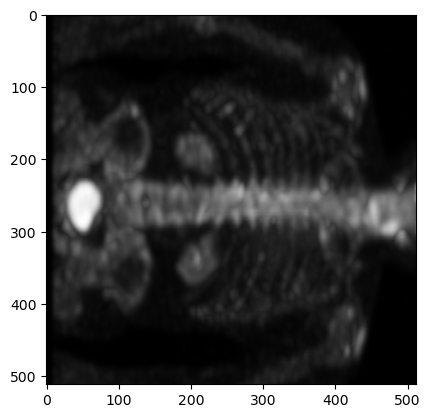

In [10]:
img, labels = next(iter(train_dataloader))
tensor = img[batch_size - 1]
# tensor.resize_(1024, 256)
# plt.figure(figsize=(4, 16))
plt.imshow(torch.tanh(torch.tanh(tensor[0] / torch.max(tensor[0]))), cmap="gray")
# plt.imshow(tensor[0], cmap="gray")
plt.show()

In [6]:
recon_loss_func = nn.CrossEntropyLoss()

In [7]:
net = UnetGenerator(1, num_classes, channel_init).cuda(0)

In [10]:
print(net)

UnetGenerator(
  (down_1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_2)

In [ ]:
optimizer = torch.optim.Adam(
    net.parameters(), lr=1e-12, weight_decay=1e-5
)  # 여기에 진짜 lr을 넣으면 안되고 작은 숫자를 넣어야 함
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)\
from cosine_annealing_with_warmup import CosineAnnealingWarmUpRestarts

scheduler = CosineAnnealingWarmUpRestarts(
    optimizer=optimizer, T_0=50, eta_max=lr, gamma=0.7, T_mult=1, T_up=10
)

In [10]:
file_model = f"./{date}_unet.pkl"
# if os.path.isfile(file_model):
#     model_dict = torch.load(file_model)
#     print("    - model restored from file....")
#     print("    - filename = %s" % file_model)

In [11]:
# or log file that has the output of our loss
train_file_loss = open(f"./{date}_unet_trian_loss", "w")
val_file_loss = open(f"./{date}_unet_val_loss", "w")

# make the result directory
if not os.path.exists(f"./{date}_result/"):
    os.makedirs(f"./{date}_result/")

if not os.path.exists(f"./{date}_models/"):
    os.makedirs(f"./{date}_models/")

In [14]:
def save_in_grid(image, path, num_row=2):
    grid = v_utils.make_grid(
        image,
        nrow=num_row,
    )
    Image.fromarray(grid.permute(1, 2, 0).numpy().astype(np.uint8)).save(path)

In [15]:
def temp_save(epoch, net, optimizer, path, scheduler=None):
    torch.save(
        {
            "epoch": epoch + 1,
            "model_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": (
                scheduler.state_dict() if scheduler is not None else None
            ),
        },
        path,
    )

In [55]:
# 다시 시작
restart = 500
epochs = 1000

train_file_loss = open(f"./{date}_unet_trian_loss", "a")
val_file_loss = open(f"./{date}_unet_val_loss", "a")
model_dict = torch.load(file_model)
optimizer.load_state_dict(model_dict["optimizer_state_dict"])
# scheduler.load_state_dict(model_dict["scheduler_state_dict"])
net.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

In [14]:
restart = 0

In [15]:
# first, save original image and label images only once
for idx_batch, (image, label) in enumerate(val_dataloader):
    # nice debug print of this epoch and its loss
    # print("epoch = " + str(epoch) + " | loss = " + str(loss.item()))

    # save the original image and label batches to file
    # 이미지로 변환 (단일 채널 grayscale로)
    normalized_image = torch.zeros(
        (image.size()[0], 3, image.size()[2], image.size()[3])
    )
    for idx in range(0, image.size()[0]):
        each_tensor = image[idx]
        each_normalized = (each_tensor - each_tensor.min()) / (
            each_tensor.max() - each_tensor.min()
        )
        normalized_image[idx] = each_normalized.repeat(3, 1, 1) * 255

    save_in_grid(
        normalized_image,
        f"./{date}_result/original_image.png",
        num_row=4,
    )

    labelrgb = torch.zeros((label.size()[0], 3, label.size()[1], label.size()[2]))
    for idx in range(0, label.size()[0]):
        labelrgb[idx] = t_dataset.class_to_rgb(label[idx])

    save_in_grid(labelrgb, f"./{date}_result/label_image.png", num_row=4)

In [ ]:
for epoch in tqdm(range(restart, epochs), desc="epochs"):
    train_total_loss = 0.0
    val_total_loss = 0.0

    # train step
    net.train()
    for idx_batch, (image, label) in enumerate(train_dataloader):

        # zero the grad of the network before feed-forward
        optimizer.zero_grad()

        # send to the GPU and do a forward pass
        x = image.cuda(0)
        y_label = label.cuda(0)
        y = net.forward(x)

        # we "squeeze" the groundtruth if we are using cross-entropy loss
        # this is because it expects to have a [N, W, H] image where the values
        # in the 2D image correspond to the class that that pixel should be 0 < pix[u,v] < classes
        with torch.set_grad_enabled(True):
            y_label = y_label.squeeze(1)
            # assert y_label.size() == (
            #     args.batch_size,
            #     512,
            #     512,
            # ), f"got size of {y_label.size()}"

            # finally calculate the loss and back propagate
            loss = recon_loss_func(y, y_label.long())
            # file에 추가로 작성
            train_total_loss += loss.item()

            loss.backward()
            optimizer.step()

        # every 400 images, save the current images
        # also checkpoint the model to disk
    train_avg_loss = train_total_loss / len(train_dataloader)
    train_file_loss.write(f"{epoch},{train_avg_loss}\n")

    net.eval()

    # validation step

    for idx_batch, (image, label) in enumerate(val_dataloader):
        with torch.no_grad():
            x = image.cuda(0)
            y_label = label.cuda(0)
            y = net.forward(x)

            y_label = y_label.squeeze(1)
            loss = recon_loss_func(y, y_label.long())
            val_total_loss += loss.item()

        if epoch % 10 == 0:
            temp_save(epoch, net, optimizer, file_model, scheduler)
            # nice debug print of this epoch and its loss
            # print("epoch = " + str(epoch) + " | loss = " + str(loss.item()))

            # save the original image and label batches to file
            # 이미지로 변환 (단일 채널 grayscale로)
            # normalized_image = torch.zeros(
            #     (image.size()[0], 3, image.size()[2], image.size()[3])
            # )
            # for idx in range(0, image.size()[0]):
            #     each_tensor = image[idx]
            #     each_normalized = (each_tensor - each_tensor.min()) / (
            #         each_tensor.max() - each_tensor.min()
            #     )
            #     normalized_image[idx] = each_normalized.repeat(3, 1, 1) * 255

            # save_in_grid(
            #     normalized_image,
            #     f"./{date}_result/original_image_{epoch}.png",
            #     num_row=4,
            # )

            # labelrgb = torch.zeros(
            #     (label.size()[0], 3, label.size()[1], label.size()[2])
            # )
            # for idx in range(0, label.size()[0]):
            #     labelrgb[idx] = dataset.class_to_rgb(label[idx])

            # save_in_grid(
            #     labelrgb, f"./{date}_result/label_image_{epoch}.png", num_row=4
            # )

            # max over the classes should be the prediction
            # our prediction is [N, classes, W, H]
            # so we max over the second dimension and take the max response
            # if we are doing rgb reconstruction, then just directly save it to file
            y_threshed = torch.zeros((y.size()[0], 3, y.size()[2], y.size()[3]))
            for idx in range(0, y.size()[0]):
                maxindex = torch.argmax(y[idx], dim=0).cpu().int()
                y_threshed[idx] = v_dataset.class_to_rgb(maxindex)

            save_in_grid(
                y_threshed, f"./{date}_result/gen_image_{epoch}.png", num_row=4
            )

    val_avg_loss = val_total_loss / len(val_dataloader)
    val_file_loss.write(f"{epoch},{val_avg_loss}\n")
    print(f"epoch = {epoch} | val loss = {val_avg_loss}")

    # model save

    if epoch % 50 == 0:
        file_model_epoch = f"./{date}_models/{date}_unet_{epoch}.pkl"
    temp_save(epoch, net, optimizer, file_model_epoch, scheduler)
    # finally checkpoint this file to disk

    scheduler.step()

train_file_loss.close()
val_file_loss.close()

In [ ]:
# 오리지널과 레이블 이미지는 한번만 저장해도 됨 결국 9개 테스트 이미지는 계속 같으니까

In [17]:
# 열은 파일 닫기
train_file_loss.close()
val_file_loss.close()

## Evaluation

In [8]:
file_model = "/projects3/pi/nhcho/Sev_WBBS/skhyun/segmentation/scripts/1029_2047_models/1029_2047_unet_1000.pkl"
model_dict = torch.load(file_model)
# optimizer.load_state_dict(model_dict["optimizer_state_dict"])
# scheduler.load_state_dict(model_dict["scheduler_state_dict"])
net.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

In [10]:
import pandas as pd

In [12]:
# IoU와 Dice 계산 validation 2번 환자 레이블이 너무 이상한데??

net.eval()

# validation step

for idx_batch, (image, label) in enumerate(val_dataloader):
    with torch.no_grad():
        x = image.cuda(0)
        y_label = label
        y = net(x)

        y_label = y_label.squeeze(1)  # [N, 1, W, H] -> [N, W, H]

        # max over the classes should be the prediction
        # our prediction is [N, classes, W, H]
        # so we max over the second dimension and take the max response
        # if we are doing rgb reconstruction, then just directly save it to file

    # 0~16까지로 된 예측 label
    y_BnW = []

    for idx in range(0, y.size()[0]):

        maxindex = torch.argmax(y[idx], dim=0).cpu().int()  # [W, H]
        y_BnW.append(maxindex)

    # 각 9개의 환자에 대해 IoU와 Dice 계산 후 평균
    # 단 11번 클래스에 대해서만 계산
    # 즉 [9, W, H] 이미지에서 11번으로 분류된건 1, 그 외에는 0으로 다시 이진화 작업
    bone_num = 3
    # y_BnW = [y == bone_num for y in y_BnW]
    # y_label = [y == bone_num for y in y_label]

    show_idx = 1
    # show_idx번 환자에 대해, y_BnW는 1, y_label은 2, y_BnW와 y_label이 겹치는건 3으로 new_img에 그리기
    # new_img = torch.zeros((512, 512))
    # new_img[y_BnW[show_idx]] = 1
    # new_img[y_label[show_idx]] = 2
    # new_img[torch.logical_and(y_BnW[show_idx], y_label[show_idx])] = 3
    # plt.imshow(new_img)

    # plt.imshow(y_BnW[show_idx])

    # 아예 bone에 대해서, patient별로 IoU와 Dice 계산하여 dataFrame으로 저장 최종 엑셀파일로
    IoU_table = []
    Dice_table = []
    for bone_idx in range(1, 16):

        y_BnW_idx = [y == bone_idx for y in y_BnW]
        y_label_idx = [y == bone_idx for y in y_label]

        IoU_list = []
        Dice_list = []
        for patient_idx in range(9):
            if patient_idx == 2:
                continue
            intersection = torch.logical_and(
                y_BnW_idx[patient_idx], y_label_idx[patient_idx]
            ).sum()
            union = torch.logical_or(
                y_BnW_idx[patient_idx], y_label_idx[patient_idx]
            ).sum()
            iou = intersection / union

            dice = (
                2
                * intersection
                / (y_BnW_idx[patient_idx].sum() + y_label_idx[patient_idx].sum())
            )
            IoU_list.append(iou)
            Dice_list.append(dice)
        IoU_table.append(IoU_list)
        Dice_table.append(Dice_list)

    IoU_table = np.array(IoU_table)
    Dice_table = np.array(Dice_table)

    IoU_table = pd.DataFrame(IoU_table)
    Dice_table = pd.DataFrame(Dice_table)

    IoU_table.to_excel(f"./IoU_table.xlsx")
    Dice_table.to_excel(f"./Dice_table.xlsx")

    # for i in range(len(y_BnW)):
    #     # y_BnW[i] = y_BnW[i].unsqueeze(0)  # [W, H] -> [1, W, H]
    #     # y_label[i] = y_label[i].unsqueeze(0)  # [W, H] -> [1, W, H]

    #     # IoU 계산
    #     intersection = torch.logical_and(y_BnW[i], y_label[i]).sum()
    #     union = torch.logical_or(y_BnW[i], y_label[i]).sum()
    #     iou = intersection / union

    #     # Dice 계산
    #     dice = 2 * intersection / (y_BnW[i].sum() + y_label[i].sum())

    #     print(f"Patient {i} | IoU : {iou} | Dice : {dice}")

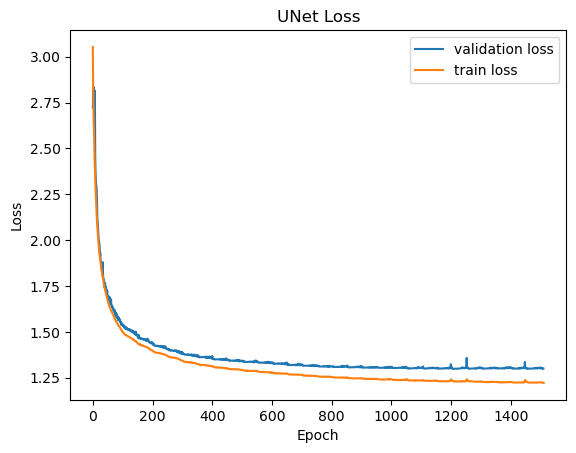

In [18]:
# unet_val_loss 열어서 그래프 그리기


val_loss = np.loadtxt(
    f"/projects3/pi/nhcho/Sev_WBBS/skhyun/segmentation/scripts/{date}_unet_val_loss",
    delimiter=",",
)
train_loss = np.loadtxt(
    f"/projects3/pi/nhcho/Sev_WBBS/skhyun/segmentation/scripts/{date}_unet_trian_loss",
    delimiter=",",
)

plt.plot(val_loss[:, 0], val_loss[:, 1], label="validation loss")
plt.plot(train_loss[:, 0], train_loss[:, 1], label="train loss")
# 제목
plt.title("UNet Loss")
# 축제목
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()